In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from gensim.models.phrases import Phrases, Phraser
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
import tensorflow as tf
np.random.seed(999)
tf.random.set_seed(999)

# Load the dataset
df = pd.read_csv('../data/News Articles/Labelled/Kraggle_labelled.csv', encoding='ISO-8859-1', on_bad_lines='skip', header=None)
df = df.dropna()

# Define a function to preprocess the text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic characters
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Apply the function to preprocess the 'data' column
df['processed_content'] = df[1].apply(preprocess_text)

df = pd.DataFrame({
    'processed_content': df['processed_content'],
    'sentiment': df[0]
})

df.head()

# Apply bigram/trigram preprocessing
bigram_model = Phrases(df['processed_content'], min_count=1, threshold=10)
trigram_model = Phrases(bigram_model[df['processed_content']], min_count=1, threshold=10)
bigram_phraser = Phraser(bigram_model)
trigram_phraser = Phraser(trigram_model)
df['processed_content_phrased'] = df['processed_content'].apply(
    lambda x: trigram_phraser[bigram_phraser[x]]
)

# Convert sentiment labels to numerical (if not already)
label_map = {'neutral': 1, 'none': 1, 'positive': 2, 'negative': 0}
if df['sentiment'].dtype == 'object':
    df['sentiment'] = df['sentiment'].map(label_map)

# Split data
X = df['processed_content_phrased']
y = df['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 3392, Val: 974, Test: 480


In [4]:
# 2. TF-IDF Model with Custom Vocabulary

from keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer

positive_terms = [
    'profit', 'rose', 'increased', 'increase', 'agreement', 'signed', 'contract',
    'growth', 'grew', 'awarded', 'positive', 'operating profit', 'net profit',
    'profit rose', 'period increased', 'sales increased', 'signed agreement',
    'increased respectively', 'loss narrowed', 'pretax profit', 'profit period',
    'sales rose', 'profit net', 'grew percent', 'awarded contract', 'sales increase',
    'profit increased', 'cost savings', 'expected increase', 'profit totalled',
    'operating profit rose', 'net profit rose', 'period increased revenue',
    'increased respectively compared', 'net sales increased', 'sales period increased',
    'operating profit net', 'profit net sales', 'today net profit', 'sales rose net',
    'operating profit increased', 'net sales rose', 'net sales increase',
    'said net profit', 'operating profit totalled', 'operating profit period',
    'grew percent million'
]

negative_terms = [
    'loss', 'decreased', 'fell', 'lower', 'cut', 'dropped', 'negative',
    'declined', 'warning', 'laid', 'decreased eur', 'operating loss',
    'net loss', 'profit fell', 'sales decreased', 'profit decreased',
    'profit warning', 'loss totalled', 'pct lower', 'period decreased',
    'pretax loss', 'today slipped', 'sales fell', 'slipped net',
    'personnel reductions', 'fell percent', 'loss totaled', 'decreased net',
    'laid off', 'operating profit fell', 'profit period decreased',
    'operating loss totalled', 'period decreased net', 'net sales decreased',
    'said today slipped', 'decreased net sales', 'net profit decreased',
    'slipped net loss', 'issued profit warning', 'net profit fell',
    'operating profit decreased', 'today slipped net'
]

vocabulary = positive_terms + negative_terms

# Normalize terms for TF-IDF (replace underscores with spaces if needed)
vocabulary = [term.replace('_', ' ') for term in vocabulary]

# Using your exact TF-IDF setup
vectorizer = TfidfVectorizer(
    vocabulary=vocabulary,
    ngram_range=(1, 3),  # Changed from (0,3) to (1,3) as (0,3) is invalid
    lowercase=False
)

# Convert text to TF-IDF features using your phrased content
X_train_tfidf = vectorizer.fit_transform([' '.join(x) for x in X_train])
X_val_tfidf = vectorizer.transform([' '.join(x) for x in X_val])
X_test_tfidf = vectorizer.transform([' '.join(x) for x in X_test])
print("TF-IDF shape:", X_train_tfidf.shape)

# Convert labels to numerical format using your label_map
# Note: Using your label_map {'neutral':1, 'none':1, 'positive':2, 'negative':0}
y_train_enc = y_train.values
y_val_enc = y_val.values
y_test_enc = y_test.values

# One-hot encode labels
num_classes = 3  # For your 3 classes (0:negative, 1:neutral, 2:positive)
y_train_onehot = to_categorical(y_train_enc, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_enc, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_enc, num_classes=num_classes)

TF-IDF shape: (3392, 89)


In [5]:
# 3. ANN with Your Custom TF-IDF Features

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from keras.callbacks import EarlyStopping

def build_ann_tfidf(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

ann_tfidf = build_ann_tfidf(X_train_tfidf.shape[1])
ann_tfidf.summary()

# Train ANN
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_ann = ann_tfidf.fit(
    X_train_tfidf.toarray(), y_train_onehot,
    validation_data=(X_val_tfidf.toarray(), y_val_onehot),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,491 (146.45 KB)

 Trainable params: 37,491 (146.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5762 - loss: 1.0355 - val_accuracy: 0.6109 - val_loss: 0.8938
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6131 - loss: 0.9253 - val_accuracy: 0.6191 - val_loss: 0.8814
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6203 - loss: 0.9093 - val_accuracy: 0.6253 - val_loss: 0.8771
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6275 - loss: 0.9042 - val_accuracy: 0.6273 - val_loss: 0.8778
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6269 - loss: 0.8947 - val_accuracy: 0.6273 - val_loss: 0.8744
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6204 - loss: 0.9057 - val_accuracy: 0.6273 - val_loss: 0.8715
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6226 - loss: 0.8998 - val_accuracy: 0.6273 - val_loss: 0.8711
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6249 - loss: 0.8989 - val_accuracy: 0.

In [ ]:
# 4. LSTM Model using Your Processed Content

from keras.layers import TextVectorization
import tensorflow as tf

# Parameters
max_words = 10000  # Vocabulary size
max_len = 100      # Sequence length

# Combine training data into plain text format if needed
X_train_text = [' '.join(doc) for doc in X_train]
X_val_text = [' '.join(doc) for doc in X_val]
X_test_text = [' '.join(doc) for doc in X_test]

# Define the TextVectorization layer
vectorizer = TextVectorization(
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=max_len
)

# Adapt to training data
vectorizer.adapt(X_train_text)

# Vectorize datasets
X_train_seq = vectorizer(X_train_text)
X_val_seq = vectorizer(X_val_text)
X_test_seq = vectorizer(X_test_text)

# Convert to NumPy arrays (optional, depending on your model setup)
X_train_seq = X_train_seq.numpy()
X_val_seq = X_val_seq.numpy()
X_test_seq = X_test_seq.numpy()

# Build LSTM model
def build_lstm_model():
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        SpatialDropout1D(0.2),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

# Train LSTM
history_lstm = lstm_model.fit(
    X_train_seq, y_train_onehot,
    validation_data=(X_val_seq, y_val_onehot),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

NameError: name 'Tokenizer' is not defined

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Convert sparse matrices to dense arrays
X_train_dense = X_train_tfidf.toarray()
X_val_dense = X_val_tfidf.toarray()

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_dense, y_train_enc)

# Predictions
y_pred_xgb = xgb_model.predict(X_val_dense)
accuracy = accuracy_score(y_val_enc, y_pred_xgb)
print(f"XGBoost Validation Accuracy: {accuracy:.4f}")

XGBoost Validation Accuracy: 0.6263



=== TF-IDF ANN Evaluation ===
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

ANN with TF-IDF Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.09      0.16        64
     neutral       0.60      0.95      0.73       275
    positive       0.58      0.15      0.24       141

    accuracy                           0.60       480
   macro avg       0.58      0.40      0.38       480
weighted avg       0.59      0.60      0.51       480



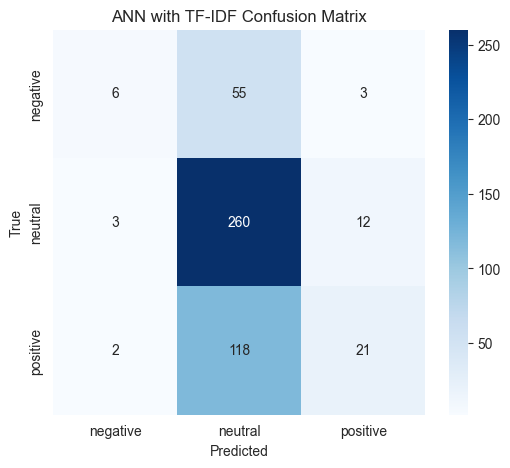


=== LSTM Evaluation ===
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.41      0.50        64
     neutral       0.76      0.86      0.81       275
    positive       0.58      0.54      0.56       141

    accuracy                           0.71       480
   macro avg       0.67      0.60      0.62       480
weighted avg       0.70      0.71      0.70       480



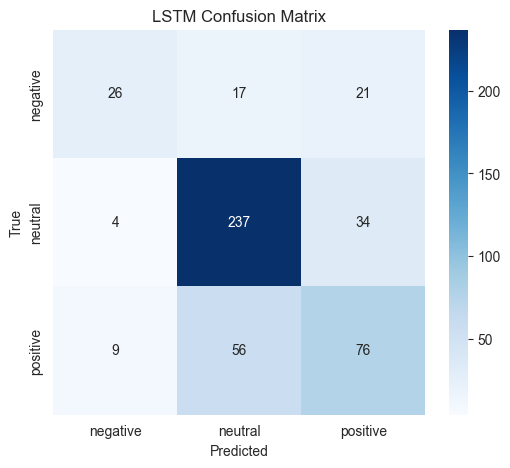

In [ ]:
# 5. Evaluation and Comparison

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    if len(y_test.shape) > 1:  # If one-hot encoded
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test

    y_pred = np.argmax(model.predict(X_test), axis=1)

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test_labels, y_pred,
                              target_names=['negative', 'neutral', 'positive']))

    plt.figure(figsize=(6,5))
    cm = confusion_matrix(y_test_labels, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return accuracy_score(y_test_labels, y_pred)

# Evaluate all models
print("\n=== TF-IDF ANN Evaluation ===")
tfidf_ann_acc = evaluate_model(ann_tfidf, X_test_tfidf.toarray(), y_test_onehot, "ANN with TF-IDF")

print("\n=== LSTM Evaluation ===")
lstm_acc = evaluate_model(lstm_model, X_train_seq, y_test_onehot, "LSTM")


Training History for ANN with TF-IDF:


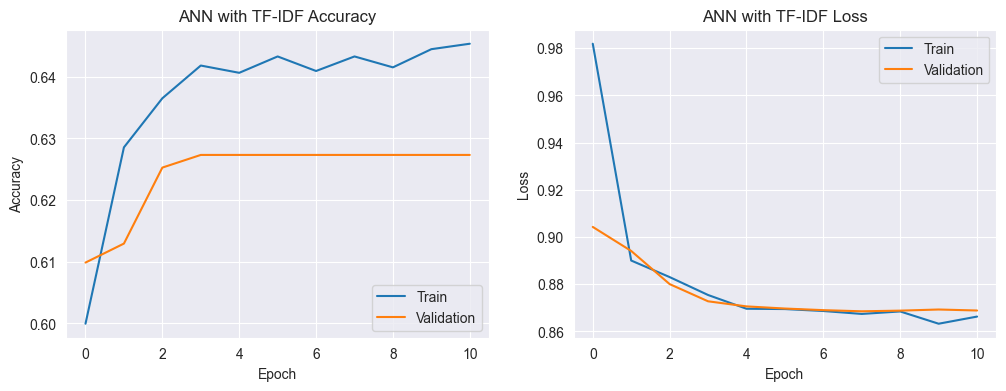


Training History for LSTM:


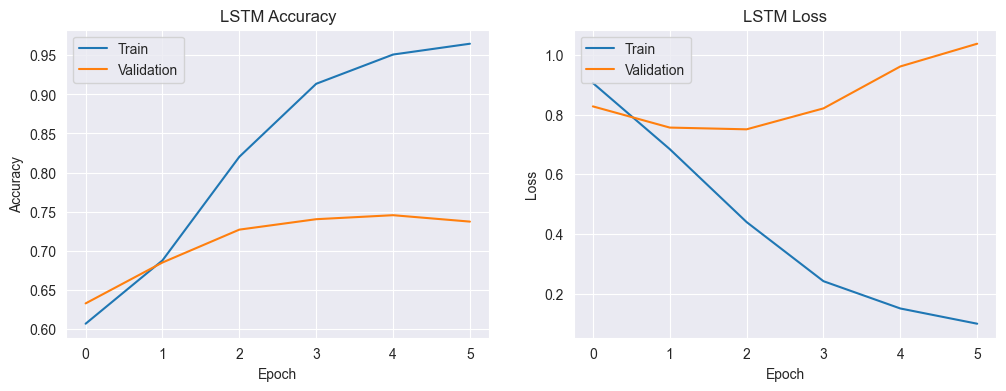

In [ ]:
# 6. Training History Visualization
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

print("\nTraining History for ANN with TF-IDF:")
plot_history(history_ann, "ANN with TF-IDF")

print("\nTraining History for LSTM:")
plot_history(history_lstm, "LSTM")

In [ ]:
# 7. Model Comparison
results = pd.DataFrame({
    'Model': ['ANN with Custom TF-IDF', 'LSTM'],
    'Accuracy': [tfidf_ann_acc, lstm_acc],
    'Parameters': [ann_tfidf.count_params(), lstm_model.count_params()]
})

print("\nModel Comparison:")
print(results)



Model Comparison:
                    Model  Accuracy  Parameters
0  ANN with Custom TF-IDF  0.597917       56323
1                    LSTM  0.706250     1411971
